### processing.py's code in a notebook for interactivity. Also attempts some contour length calculations. Doesn't yet convert to physical units though.

# Setup

In [98]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, fixed
import cv2

OUTPUT_DIR = '../../out'
NRRD1_PATH = '../../ExampleData/BCP_Dataset_2month_T1w.nrrd'
NRRD2_PATH = '../../ExampleData/IBIS_Dataset_12month_T1w.nrrd'
NRRD3_PATH = '../../ExampleData/IBIS_Dataset_NotAligned_6month_T1w.nrrd'
"""This is an intentionally misaligned image."""
NIFTI_PATH = '../../ExampleData/MicroBiome_1month_T1w.nii.gz'

reader = sitk.ImageFileReader()
reader.SetFileName(NIFTI_PATH)
image = reader.Execute()
print(f'Dimensions: {image.GetSize()[0]}, {image.GetSize()[1]}, {image.GetSize()[2]}')

Dimensions: 244, 292, 198


# Helper functions

In [99]:
def resample_display(img, theta_x, theta_y, theta_z, slice_z):
    """
    Apply Otsu, hole filling, and 3D image, used for interactivity with ipywidget's interact().
    
    Parameters
    ----------
    img
        Result of sitk.ImageFileReader().Execute() on a NRRD or NIfTI
    theta_x, theta_y, theta_z
        In degrees
    slice_z
        The number of the slice"""

    euler_3d_transform = sitk.Euler3DTransform()
    euler_3d_transform.SetCenter(img.TransformContinuousIndexToPhysicalPoint([((dimension - 1) / 2.0) for dimension in img.GetSize()]))
    euler_3d_transform.SetRotation(degrees_to_radians(theta_x), degrees_to_radians(theta_y), degrees_to_radians(theta_z))
    rotated_image = sitk.Resample(img, euler_3d_transform)
    rotated_image_slice = rotated_image[:,:,slice_z]

    otsu = sitk.OtsuThresholdImageFilter().Execute(rotated_image_slice)

    hole_filling = sitk.BinaryGrindPeakImageFilter().Execute(otsu)

    # BinaryGrindPeakImageFilter has inverted foreground/background 0 and 1
    inverted = sitk.NotImageFilter().Execute(hole_filling)

    largest_component = select_largest_component(inverted)

    contour = sitk.BinaryContourImageFilter().Execute(largest_component)

    plt.imshow(sitk.GetArrayFromImage(contour))
    plt.axis("off")
    plt.show()

    return contour


def degrees_to_radians(num: float):
    return num * np.pi / 180


def select_largest_component(binary_slice):
    component_image = sitk.ConnectedComponent(binary_slice)
    sorted_component_image = sitk.RelabelComponent(component_image, sortByObjectSize=True)
    largest_component_binary_image = sorted_component_image == 1
    return largest_component_binary_image


def write_sitk_slice(slice: sitk.Image, filename):
    """Write a 2D slice to the file `filename`, for testing purposes."""
    with open(filename, 'w') as f:
        for x in range(slice.GetSize()[0]):
            for y in range(slice.GetSize()[1]):
                f.write(f'{slice.GetPixel(x, y)}')
            f.write('\n')
        

def write_numpy_matrix(matrix: np.ndarray, filename):
    """Write numpy matrix representation of sitk.Image resulting from sitk.GetArrayFromImage to a text file.
    
    numpy has flipped (transposed) x and y. Must write matrix[j][i] to get the same result as `write_slice`.
    
    Warning, sitk.GetArrayFromImage returns a transposed representation of the sitk.Image."""
    with open(filename, 'w') as f:
        for i in range(len(matrix[0])):
            for j in range(len(matrix)):
                f.write(str(matrix[j][i]))
            f.write('\n')


def show_fiji(image: sitk.Image) -> None:
    sitk.Show(sitk.Cast(image,sitk.sitkFloat32) + 255)


# Interactive display

In [100]:
interact(
    resample_display,
    img=fixed(image),
    theta_x=(-180, 180),
    theta_y=(-180, 180),
    theta_z=(-180, 180),
    slice_z=(0, image.GetSize()[2] - 1)
)

interactive(children=(IntSlider(value=0, description='theta_x', max=180, min=-180), IntSlider(value=0, descrip…

<function __main__.resample_display(img, theta_x, theta_y, theta_z, slice_z)>

# Open a slice in Fiji for testing purposes

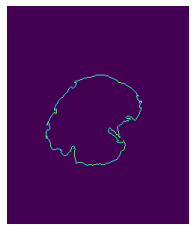

In [101]:
# slice 187 gets a wrong result
contour_slice = resample_display(image, 0, 0, 0, 0)
# show_fiji(contour)

# Get contour length

In [102]:
from PIL import Image
write_sitk_slice(contour_slice, 'contour_sitk.txt')

# Binary matrix with 0's and 1's
temp: np.ndarray = sitk.GetArrayFromImage(contour_slice)

# For testing
write_numpy_matrix(temp, 'contour_numpy.txt')

# This returns the same result for binary arrays with 0's and 1's and binary arrays with 0's and 255's, see test_imgproc.py
# contours is a list of contours since there could be multiple contours. That is, contours[0] might be the outer contour and contours[1] might be the inner contour.
contours, hierarchy = cv2.findContours(temp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour = contours[0]
circumference_1 = cv2.arcLength(contour, True)

contour = contours[1]
circumference_2 = cv2.arcLength(contour, True)

# contour = contours[2]
# circumference_3 = cv2.arcLength(contour, True)

print(f'I think circumference_1 is the outer contour and circumference 2 is the inner contour but this might be different for different images.\nCheck on the NIFTI image with rotation = (0, 0, 0) and slice_z = 150.')
print(f'Circumference 1: {circumference_1}')
print(f'Circumference 2: {circumference_2}')
# print(f'Circumference 3: {circumference_3}')

I think circumference_1 is the outer contour and circumference 2 is the inner contour but this might be different for different images.
Check on the NIFTI image with rotation = (0, 0, 0) and slice_z = 150.
Circumference 1: 594.7838318347931
Circumference 2: 539.2274831533432
